Load data and get constants

In [1]:
from flopa.io.ptuio.reader import TTTRReader
from flopa.io.ptuio.utils import estimate_tcspc_bins
from flopa.io.ptuio.decoder import T3OverflowCorrector
import numpy as np

reader = TTTRReader('../tests/data/Infinity/MultiHarp150_2025-07-09_17-16-49.326_500px_1accu_STAR488.ptu')

wrap = reader.header.tags.get("TTResultFormat_WrapAround", 1024)  # default fallback
repetition_rate = reader.header.tags.get("TTResult_SyncRate",40e6)  
tcspc_resolution = reader.header.tags.get("MeasDesc_Resolution",5e-12)
tcspc_bins = estimate_tcspc_bins(reader.header.tags,buffer=0)
TCSPCresol = reader.header.tags.get("MeasDesc_Resolution")

corrector = T3OverflowCorrector(wraparound=wrap)
omega = 2 * np.pi * repetition_rate * tcspc_resolution # should be in channel units


In [2]:
from flopa.io.ptuio.reconstructor import ScanConfig
from flopa.io.ptuio.reconstructor import ImageReconstructor

cfg = ScanConfig(
    bidirectional=False, 
    frames= 1,
    lines=500, 
    pixels=500, 
    line_accumulations= (1,),
    max_detector=2
    )

reconstructor = ImageReconstructor(
        config=cfg, 
        omega=omega, 
        tcspc_channels= tcspc_bins,
        )

for chunk in reader.iter_chunks():
    corrected_chunk = corrector.correct(chunk)
    reconstructor.update(corrected_chunk)

result = reconstructor.finalize()

TCSPC channel overflow detected! Max channel: 5028
TCSPC channel overflow detected! Max channel: 5027
TCSPC channel overflow detected! Max channel: 5039
TCSPC channel overflow detected! Max channel: 5030
TCSPC channel overflow detected! Max channel: 5026
TCSPC channel overflow detected! Max channel: 5027
TCSPC channel overflow detected! Max channel: 5034


Get the reconstructed data

In [3]:
count = result.photon_count
lifetime = result.mean_arrival_time
g = result.phasor_g
s = result.phasor_s
decay = result.tcspc_histogram
# Slice
count = count.isel(frame=0,sequence=0,detector=0)
lifetime = lifetime.isel(frame=0,sequence=0,detector=0)
g = g.isel(frame=0,sequence=0,detector=0)
s = s.isel(frame=0,sequence=0,detector=0)
decay = decay.isel(frame=0,sequence=0,detector=0)

# Convert to numpy
count = np.array(count,dtype=int)
lifetime = np.array(lifetime * tcspc_resolution, dtype = float)
g = np.array(g,dtype=float)
s = np.array(s,dtype=float)
phasor = (g + 1j * s).astype(np.complex64)


Smooth and show pixel phasors

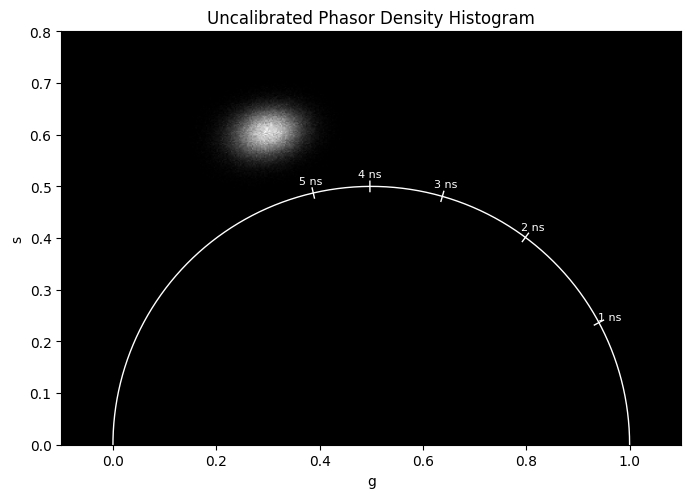

In [4]:
import matplotlib.pyplot as plt
from flopa.io.ptuio.utils import smooth_weighted, draw_unitary_circle

g_smooth, _ = smooth_weighted(g, count,size = 3)
s_smooth, _ = smooth_weighted(s, count,size = 3)
phasor_smoothed = (g_smooth + 1j * s_smooth).astype(np.complex64)

valid = np.isfinite(phasor) & (count > 0)


H, xedges, yedges = np.histogram2d(g_smooth.ravel(), s_smooth.ravel(), bins=150)


fig, ax = plt.subplots(figsize=(8,6))

ax.imshow(H.T, origin='lower',
          extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
          cmap='gray', aspect='equal')
ax.set_xlabel('g')
ax.set_ylabel('s')
ax.set_title('Uncalibrated Phasor Density Histogram')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_facecolor('black')


draw_unitary_circle(ax, sync_rate=repetition_rate, tau_max = 5)

# ax.plot(phasor_measured.real,phasor_measured.imag,"rs")
plt.show()



Calculate phasor from TCSPC histogram by numerical integration or by weight-averaging phasor from all pixels



In [5]:
from flopa.io.ptuio.utils import average_phasor, get_phasor_from_decay

# Option 1: Calculate phasor from TCSPC histogram by numerical integration
phasor_from_decay = get_phasor_from_decay(decay=decay.data, tcspc_resolution=tcspc_resolution,sync_rate=repetition_rate)
print("Phasor calculated from the TCSPC histogram", phasor_from_decay)

# Option 2: Calculate phasor by weight-averaging phasor from all pixels
phasor_from_image = average_phasor(phasor,count,mask=None) # will give the same result as with mask=None
print("Average phasor calcuated from all pixels: ", phasor_from_image)


Phasor calculated from the TCSPC histogram (0.2977174449726273+0.6022318343632526j)
Average phasor calcuated from all pixels:  (0.2977174502554028+0.6022318482012163j)


Calibrate phasor

Theoretical phasor for lifetime 3.834 ns: 0.519 + 0.500j
Calibration factor:  1.009 + -0.362j


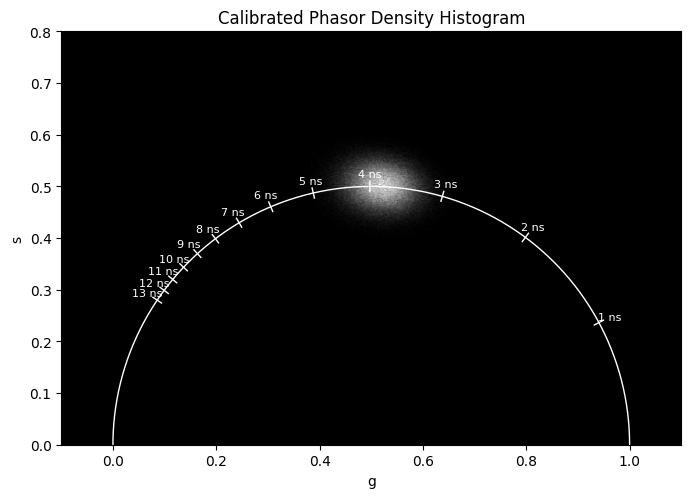

In [6]:
tau = 3.834e-9 # recorded lifetime of STAR 488 in water

phasor_theory = complex(1 / (1 - 1j * 2 * np.pi * repetition_rate * tau))

print(f"Theoretical phasor for lifetime {tau * 1e9 :.3f} ns: {phasor_theory.real :.3f} + {phasor_theory.imag :.3f}j")

calibration_factor = phasor_theory / phasor_from_decay
print(f"Calibration factor: {calibration_factor.real: 0.3f} + {calibration_factor.imag: .3f}j")

# Calibration is simple complex multiplication
phasor_calibrated = phasor * calibration_factor
# phasor_calibrated_smoothed = smooth_phasor(phasor_calibrated,count)

g_calibrated_smooth, _ = smooth_weighted(phasor_calibrated.real,count, size = 3)
s_calibrated_smooth, _ = smooth_weighted(phasor_calibrated.imag,count, size = 3)

valid = valid = np.isfinite(phasor) & (count > 0)


g_calibrated_smooth = g_calibrated_smooth[valid]
s_calibrated_smooth = s_calibrated_smooth[valid]

H, xedges, yedges = np.histogram2d(g_calibrated_smooth, s_calibrated_smooth, bins=150)

fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(H.T, origin='lower',
          extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
          cmap='gray', aspect='equal')
ax.set_xlabel('g')
ax.set_ylabel('s')
ax.set_title('Calibrated Phasor Density Histogram')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_facecolor('black')

draw_unitary_circle(ax=ax,sync_rate=repetition_rate)
plt.show()


Hack: making the lowest 2D histogram value transparent using alpha channel

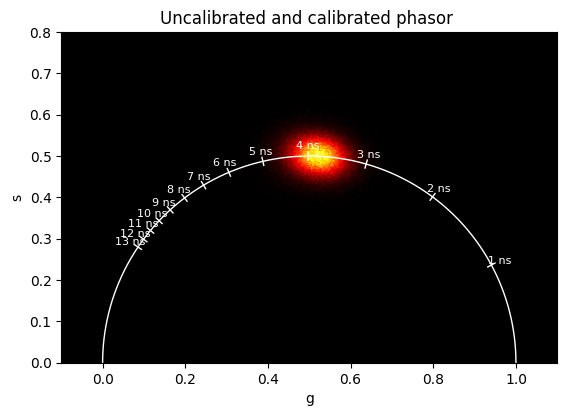

In [7]:
# Create alpha mask: transparent where H == min(H)
alpha = np.ones_like(H, dtype=float)
alpha[H == H.min()] = 0.0

fig, ax = plt.subplots()

draw_unitary_circle(ax,sync_rate=repetition_rate)


H, xedges, yedges = np.histogram2d(g_calibrated_smooth, s_calibrated_smooth, bins=150)
alpha = np.ones_like(H, dtype=float)
alpha[H == H.min()] = 0.0
im = ax.imshow(
    H.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='hot',
    aspect='equal',
    alpha=alpha.T  # transpose alpha to match H.T
)
ax.set_facecolor("black")
plt.title('Uncalibrated and calibrated phasor ')
plt.show()


Fast & dirty calibration by shifting the decay

Orgiginal phasor value: 0.298 + 0.602j
Phasor adjusted by decay shift:  0.451 +  0.498j
Phasor adjusted by multiplication:  0.451 +  0.498j
Phasor calibrated:  0.519 +  0.500j


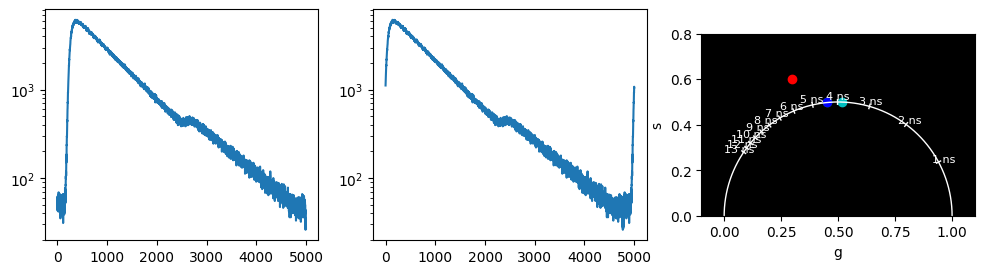

In [8]:
from flopa.io.ptuio.utils import shift_decay

shift = 220

decay_shifted = shift_decay(decay.data,shift)

phasor = get_phasor_from_decay(decay=decay.data,tcspc_resolution=tcspc_resolution,sync_rate=repetition_rate)
phasor_from_decay_shifted = get_phasor_from_decay(decay_shifted,tcspc_resolution=tcspc_resolution,sync_rate=repetition_rate)
phasor_multiplied = np.exp(- 1j * shift * tcspc_resolution * 2 * np.pi * repetition_rate) * phasor # this does the same in theory
phasor_from_decay_calibrated = phasor * calibration_factor

print(f"Orgiginal phasor value: {phasor.real :.3f} + {phasor.imag :.3f}j")
print(f"Phasor adjusted by decay shift: {phasor_from_decay_shifted.real: .3f} + {phasor_from_decay_shifted.imag: .3f}j")
print(f"Phasor adjusted by multiplication: {phasor_multiplied.real: .3f} + {phasor_multiplied.imag: .3f}j")
print(f"Phasor calibrated: {phasor_from_decay_calibrated.real: .3f} + {phasor_from_decay_calibrated.imag: .3f}j")
# The phasor is influenced by the shift of the decay and IRF width. If the shift is selected in such a way,
# that the phasor will lie on the unitary circle, it will not be at the same coordinates as calibrated phasor
# The phasor is influenced by the shift of the decay and IRF width. 
# Suggestion: find the decay shift using derivation of the decay TODO

fig, ax = plt.subplots(1,3, figsize = (12,3))
ax[0].semilogy(decay.data)
ax[1].semilogy(decay_shifted)
ax[2].plot(phasor_from_decay.real,phasor_from_decay.imag,'ro')
ax[2].plot(phasor_from_decay_shifted.real,phasor_from_decay_shifted.imag,'go')
ax[2].plot(phasor_multiplied.real,phasor_multiplied.imag,'bo')
ax[2].plot(phasor_from_decay_calibrated.real,phasor_from_decay_calibrated.imag,'co')
ax[2].set_aspect(1)
ax[2].set_xlim(0,1)
ax[2].set_ylim(0,1)
ax[2].set_facecolor('black')

draw_unitary_circle(ax=ax[2],sync_rate=repetition_rate)

plt.show()

